In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca637.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3400.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca783.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3927.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca4109.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca95.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca488.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca2140.jp

In [2]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

2024-07-08 07:47:20.639650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 07:47:20.639751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 07:47:20.774945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_dir = 'train_set'
test_dir = 'test_set'

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of classes (sub-folders)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop through each class
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class directories in the train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
    
    # Copy testing images
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

In [4]:
image_set =  "/kaggle/working/train_set"
test_set_directory = '/kaggle/working/test_set'

In [5]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.5)

validate_set = test_datagen.flow_from_directory(
       test_set_directory,
       class_mode = "categorical",
       target_size = (SIZE_X, SIZE_Y),
       color_mode="rgb",
       batch_size = 128, 
       shuffle = False,
       subset='training',
       seed = 42)


test_set = test_datagen.flow_from_directory(
    test_set_directory,
    class_mode='categorical',
    target_size=(SIZE_X, SIZE_Y),
    color_mode='rgb',
    batch_size=128,
    subset='validation',
    shuffle=False  # No shuffling needed for testing
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [6]:
IMAGE_SIZE = [224, 224]

In [7]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

flatten = Flatten()(resnet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(3, activation = 'softmax')(dense)

resnet50 = Model(inputs = resnet.input, outputs = prediction )
resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,311,363 (188.11 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# COMPILING THE MODEL
resnet50.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [10]:
batch_size = 128

# resnet50 training

In [11]:
history = resnet50.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/94 ━━━━━━━━━━━━━━━━━━━━ 36:30 24s/step - accuracy: 0.0625 - loss: 2.2075

I0000 00:00:1720424998.199299     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720424998.253523     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.6358 - loss: 12.2676

W0000 00:00:1720425057.571807     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 96s 782ms/step - accuracy: 0.6375 - loss: 12.1853 - val_accuracy: 0.9507 - val_loss: 0.3719
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 538ms/step - accuracy: 0.9082 - loss: 0.7869 - val_accuracy: 0.9667 - val_loss: 0.2417
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 541ms/step - accuracy: 0.9765 - loss: 0.1162 - val_accuracy: 0.9720 - val_loss: 0.0844
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 545ms/step - accuracy: 0.9866 - loss: 0.0466 - val_accuracy: 0.9787 - val_loss: 0.0804
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 539ms/step - accuracy: 0.9911 - loss: 0.0237 - val_accuracy: 0.9827 - val_loss: 0.0714


In [16]:
def loss_curve(history):
    plt.plot(history.history['loss'],label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'testing_loss')
    plt.title('loss')
    plt.legend()
    plt.show()


In [17]:
def accuracy_curve(history):
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [19]:
def reports(model,test_set):
    from sklearn.metrics import confusion_matrix
    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred ,axis =1)
    print('Confusion Matrix')
    confusion_matrix = confusion_matrix(test_set.classes, y_pred)
    print(confusion_matrix)
    print('Classification Report')
    target_names = ['aca','n', 'scc']
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

# resnet50 evaluation

In [20]:
result = resnet50.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step - accuracy: 0.9687 - loss: 0.1164
test_loss, test accuracy [0.07524479180574417, 0.9786666631698608]


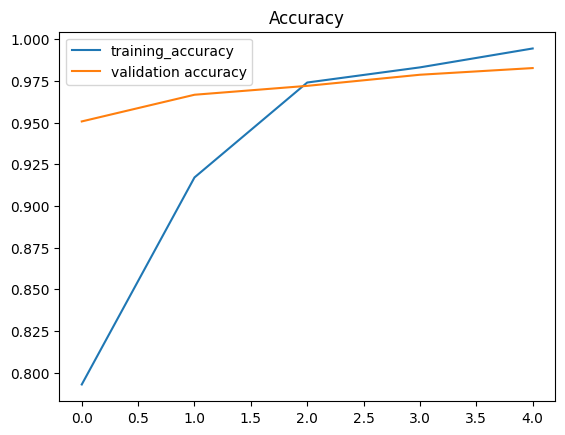

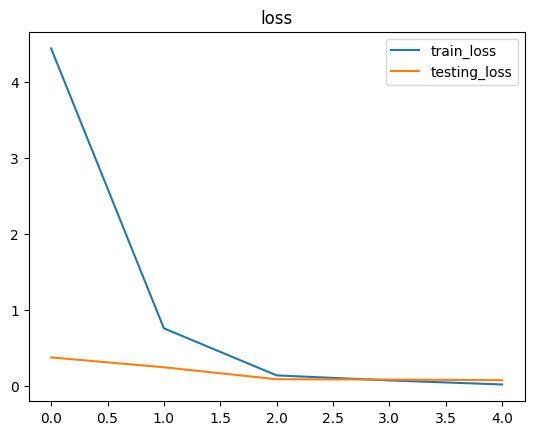

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

W0000 00:00:1720425484.208491     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step
Confusion Matrix
[[474   5  21]
 [  0 500   0]
 [  6   0 494]]
Classification Report
              precision    recall  f1-score   support

         aca       0.99      0.95      0.97       500
           n       0.99      1.00      1.00       500
         scc       0.96      0.99      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [21]:
accuracy_curve(history)
loss_curve(history)
reports(resnet50,test_set)

# EfficientNetB0

In [22]:
from tensorflow.keras.applications import EfficientNetB0
enb0 = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in enb0.layers:
        layer.trainable = False


flatten = Flatten()(enb0.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# Create the model
efnetB0 = Model(inputs=enb0.input, outputs=prediction)

# Print the model summary
efnetB0.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 20,139,430 (76.83 MB)

 Trainable params: 16,089,859 (61.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [24]:
efnetB0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# EfficientNetB0 training

In [25]:
history = efnetB0.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 133s 985ms/step - accuracy: 0.6335 - loss: 14.2764 - val_accuracy: 0.9267 - val_loss: 0.2267
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 555ms/step - accuracy: 0.9460 - loss: 0.1654 - val_accuracy: 0.9493 - val_loss: 0.1249
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 532ms/step - accuracy: 0.9364 - loss: 0.2095 - val_accuracy: 0.9807 - val_loss: 0.0546
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 541ms/step - accuracy: 0.9827 - loss: 0.0465 - val_accuracy: 0.9513 - val_loss: 0.1156
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 548ms/step - accuracy: 0.9715 - loss: 0.0767 - val_accuracy: 0.9867 - val_loss: 0.0327


# EfficientNetB0 Evaluation

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 516ms/step - accuracy: 0.9778 - loss: 0.0624
test_loss, test accuracy [0.042633023113012314, 0.984000027179718]


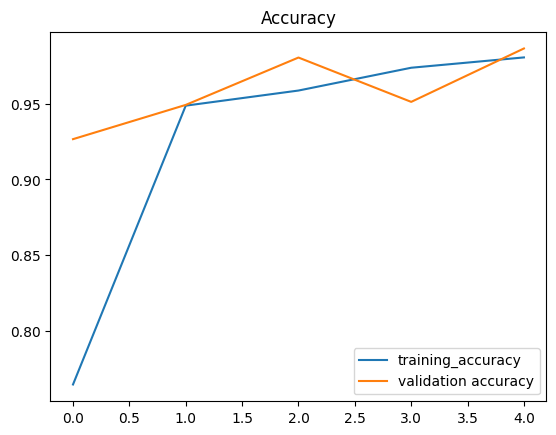

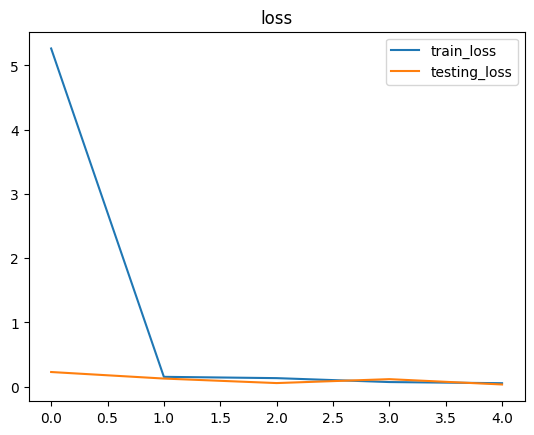

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 998ms/step
Confusion Matrix
[[484   0  16]
 [  2 498   0]
 [  6   0 494]]
Classification Report
              precision    recall  f1-score   support

         aca       0.98      0.97      0.98       500
           n       1.00      1.00      1.00       500
         scc       0.97      0.99      0.98       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [26]:
result = efnetB0.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

accuracy_curve(history)
loss_curve(history)
reports(efnetB0,test_set)

# Inception v3

In [27]:
from tensorflow.keras.applications import InceptionV3

In [28]:
# Load the InceptionV3 model
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in inception.layers:
    layer.trainable = False

# Add new layers
flatten = Flatten()(inception.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
inception = Model(inputs=inception.input, outputs=prediction)

# Print the model summary
inception.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 34,943,523 (133.30 MB)

 Trainable params: 13,140,739 (50.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [29]:
# Compile the model
inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Inception Train

In [30]:
history = inception.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 117s 927ms/step - accuracy: 0.4330 - loss: 392.2997 - val_accuracy: 0.6493 - val_loss: 115.2070
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 540ms/step - accuracy: 0.6928 - loss: 39.1549 - val_accuracy: 0.8127 - val_loss: 7.9207
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 546ms/step - accuracy: 0.7196 - loss: 16.8480 - val_accuracy: 0.7793 - val_loss: 7.4392
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 533ms/step - accuracy: 0.7953 - loss: 6.7747 - val_accuracy: 0.7707 - val_loss: 5.9471
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 548ms/step - accuracy: 0.7986 - loss: 6.3815 - val_accuracy: 0.8600 - val_loss: 2.7112


# inception evaluation

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.8136 - loss: 3.4528
test_loss, test accuracy [2.5295021533966064, 0.8666666746139526]


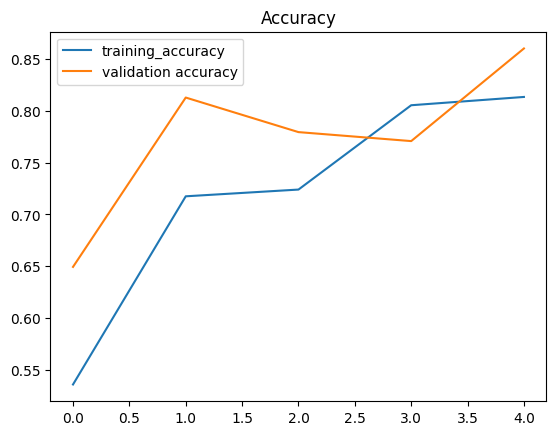

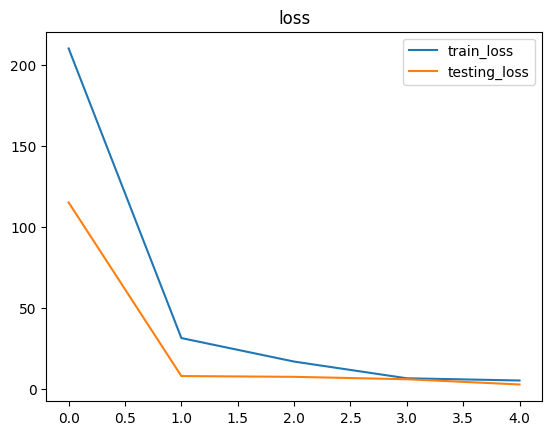

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 959ms/step
Confusion Matrix
[[376   7 117]
 [ 51 448   1]
 [ 24   0 476]]
Classification Report
              precision    recall  f1-score   support

         aca       0.83      0.75      0.79       500
           n       0.98      0.90      0.94       500
         scc       0.80      0.95      0.87       500

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



In [31]:
result = inception.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

accuracy_curve(history)
loss_curve(history)
reports(inception,test_set)

# Knowledge Distillation

# Resnet50 Teacher

In [32]:
import os
import keras
from keras import layers
from keras import ops
import numpy as np

In [33]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

# Student 1 : Efficient B0 

In [34]:
from tensorflow.keras.applications import EfficientNetB0
enb0_st = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in enb0_st.layers:
        layer.trainable = False


flatten = Flatten()(enb0_st.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
enb0_st = Model(inputs=enb0_st.input, outputs=prediction)

# Print the model summary
enb0_st.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 20,139,430 (76.83 MB)

 Trainable params: 16,089,859 (61.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [35]:
distiller_enb0_st = Distiller(student=enb0_st, teacher=resnet50)
distiller_enb0_st.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Training with KD
history_enb0_st = distiller_enb0_st.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10
 1/94 ━━━━━━━━━━━━━━━━━━━━ 45:47 30s/step - accuracy: 0.4219 - loss: 0.0000e+00

W0000 00:00:1720426439.902779     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6491 - loss: 0.0000e+00

W0000 00:00:1720426503.684823     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 104s 802ms/step - accuracy: 0.6508 - loss: 0.0000e+00 - val_accuracy: 0.6860 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.8329 - loss: 0.0000e+00 - val_accuracy: 0.9647 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 545ms/step - accuracy: 0.8877 - loss: 0.0000e+00 - val_accuracy: 0.8527 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 545ms/step - accuracy: 0.8300 - loss: 0.0000e+00 - val_accuracy: 0.8067 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 559ms/step - accuracy: 0.7522 - loss: 0.0000e+00 - val_accuracy: 0.6960 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 558ms/step - accuracy: 0.6325 - loss: 0.0000e+00 - val_accuracy: 0.6733 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 552ms/step - accuracy: 0.7232 - loss: 0.0000e+00 - val_accuracy: 0.6807 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 555ms/ste

# Student: efficientnet B0 evaluation

In [36]:
result = distiller_enb0_st.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)


reports(distiller_enb0_st,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms/step - accuracy: 0.3742 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.671999990940094, 0.671999990940094]
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 872ms/step
Confusion Matrix
[[  9   5 486]
 [  1 499   0]
 [  0   0 500]]
Classification Report
              precision    recall  f1-score   support

         aca       0.90      0.02      0.04       500
           n       0.99      1.00      0.99       500
         scc       0.51      1.00      0.67       500

    accuracy                           0.67      1500
   macro avg       0.80      0.67      0.57      1500
weighted avg       0.80      0.67      0.57      1500



# Student 2 : Efficient B3

In [37]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

enb3_st = EfficientNetB3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in enb3_st.layers:
    layer.trainable = False

flatten = Flatten()(enb3_st.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
enb3_st = Model(inputs=enb3_st.input, outputs=prediction)

# Print the model summary
enb3_st.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 30,084,658 (114.76 MB)

 Trainable params: 19,301,123 (73.63 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [38]:
distiller_enb3_st = Distiller(student=enb3_st, teacher=resnet50)
distiller_enb3_st.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Training with KD
history_enb3_st = distiller_enb3_st.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10


W0000 00:00:1720427108.670230     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.6763 - loss: 0.0000e+00

W0000 00:00:1720427187.143015     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6778 - loss: 0.0000e+00 - val_accuracy: 0.9527 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 559ms/step - accuracy: 0.9105 - loss: 0.0000e+00 - val_accuracy: 0.9420 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 584ms/step - accuracy: 0.9165 - loss: 0.0000e+00 - val_accuracy: 0.9773 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 570ms/step - accuracy: 0.8787 - loss: 0.0000e+00 - val_accuracy: 0.7800 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 578ms/step - accuracy: 0.8549 - loss: 0.0000e+00 - val_accuracy: 0.7073 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 580ms/step - accuracy: 0.7488 - loss: 0.0000e+00 - val_accuracy: 0.6753 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 560ms/step - accuracy: 0.7632 - loss: 0.0000e+00 - val_accuracy: 0.6707 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 555ms/step -

# Student: efficientnet B3 evaluation

In [39]:
result = distiller_enb3_st.evaluate(test_set, batch_size=128)
print("Test loss, Test accuracy:", result)

reports(distiller_enb3_st, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step - accuracy: 0.5818 - loss: 0.0000e+00
Test loss, Test accuracy: [0.0, 0.0, 0.781333327293396, 0.781333327293396]
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step 
Confusion Matrix
[[174  39 287]
 [  0 500   0]
 [  0   2 498]]
Classification Report
              precision    recall  f1-score   support

         aca       1.00      0.35      0.52       500
           n       0.92      1.00      0.96       500
         scc       0.63      1.00      0.78       500

    accuracy                           0.78      1500
   macro avg       0.85      0.78      0.75      1500
weighted avg       0.85      0.78      0.75      1500



# Student 3 : ResNet101

In [40]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

rn101_st = ResNet101(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in rn101_st.layers:
    layer.trainable = False

flatten = Flatten()(rn101_st.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
rn101_st = Model(inputs=rn101_st.input, outputs=prediction)

# Print the model summary
rn101_st.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 68,381,827 (260.86 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [41]:
distiller_rn101_st = Distiller(student=rn101_st, teacher=resnet50)
distiller_rn101_st.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Training with KD
history_rn101_st = distiller_rn101_st.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10


W0000 00:00:1720427813.541473     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720427813.591719     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5790 - loss: 0.0000e+00

W0000 00:00:1720427878.035474     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720427878.085129     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 107s 800ms/step - accuracy: 0.5809 - loss: 0.0000e+00 - val_accuracy: 0.9400 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 562ms/step - accuracy: 0.9437 - loss: 0.0000e+00 - val_accuracy: 0.8520 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.9260 - loss: 0.0000e+00 - val_accuracy: 0.7647 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 560ms/step - accuracy: 0.9230 - loss: 0.0000e+00 - val_accuracy: 0.9460 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 563ms/step - accuracy: 0.9069 - loss: 0.0000e+00 - val_accuracy: 0.9660 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 561ms/step - accuracy: 0.9203 - loss: 0.0000e+00 - val_accuracy: 0.8520 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 572ms/step - accuracy: 0.7900 - loss: 0.0000e+00 - val_accuracy: 0.6753 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 565ms/ste

# Student: ResNet101 evaluation

In [42]:
result = distiller_rn101_st.evaluate(test_set, batch_size=128)
print("Test loss, Test accuracy:", result)

reports(distiller_rn101_st, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.8930 - loss: 0.0000e+00
Test loss, Test accuracy: [0.0, 0.0, 0.9380000233650208, 0.9380000233650208]
 1/12 ━━━━━━━━━━━━━━━━━━━━ 1:20 7s/step

W0000 00:00:1720428414.203176     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
Confusion Matrix
[[417  27  56]
 [  0 500   0]
 [ 10   0 490]]
Classification Report
              precision    recall  f1-score   support

         aca       0.98      0.83      0.90       500
           n       0.95      1.00      0.97       500
         scc       0.90      0.98      0.94       500

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



# Student 4 : VGG16

In [43]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

vgg16_st = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg16_st.layers:
    layer.trainable = False

flatten = Flatten()(vgg16_st.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
vgg16_st = Model(inputs=vgg16_st.input, outputs=prediction)

# Print the model summary
vgg16_st.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,170,755 (80.76 MB)

 Trainable params: 6,456,067 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [44]:
distiller_vgg16_st = Distiller(student=vgg16_st, teacher=resnet50)
distiller_vgg16_st.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Training with KD
history_vgg16_st = distiller_vgg16_st.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10


2024-07-08 08:47:23.704547: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-08 08:47:25.537864: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.47892, expected 2.11754
2024-07-08 08:47:25.538140: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50092: 2.52229, expected 2.16091
2024-07-08 08:47:25.538159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50149: 2.61231, expected 2.25092
2024-07-08 08:47:25.538177: E external/local_xla/xla/service/gpu/buffer_comparato

 6/94 ━━━━━━━━━━━━━━━━━━━━ 42s 487ms/step - accuracy: 0.4677 - loss: 0.0000e+00

2024-07-08 08:48:28.700065: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[96,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-08 08:48:29.816222: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.45336, expected 2.01081
2024-07-08 08:48:29.816285: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 2.78468, expected 2.34212
2024-07-08 08:48:29.816297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 3.40726, expected 2.96471
2024-07-08 08:48:29.816311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5812 - loss: 0.0000e+00

W0000 00:00:1720428602.543335     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-08 08:50:09.766526: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[92,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[92,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-08 08:50:10.789266: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.93093, expected 3.09758
2024-07-08 08:50:10.789334: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.14004, expected 4.30669
2024-07-08 08:50:10.789349: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Dif

94/94 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.5827 - loss: 0.0000e+00 - val_accuracy: 0.9460 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 562ms/step - accuracy: 0.9297 - loss: 0.0000e+00 - val_accuracy: 0.9693 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - accuracy: 0.9538 - loss: 0.0000e+00 - val_accuracy: 0.9673 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 572ms/step - accuracy: 0.9837 - loss: 0.0000e+00 - val_accuracy: 0.9820 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 561ms/step - accuracy: 0.9893 - loss: 0.0000e+00 - val_accuracy: 0.9827 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 552ms/step - accuracy: 0.9881 - loss: 0.0000e+00 - val_accuracy: 0.9827 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 578ms/step - accuracy: 0.9969 - loss: 0.0000e+00 - val_accuracy: 0.9827 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 560ms/step -

# Student: VGG16 evaluation

In [45]:
result = distiller_vgg16_st.evaluate(test_set, batch_size=128)
print("Test loss, Test accuracy:", result)

reports(distiller_vgg16_st, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - accuracy: 0.9522 - loss: 0.0000e+00
Test loss, Test accuracy: [0.0, 0.0, 0.9700000286102295, 0.9700000286102295]
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step
Confusion Matrix
[[461   1  38]
 [  1 499   0]
 [  5   0 495]]
Classification Report
              precision    recall  f1-score   support

         aca       0.99      0.92      0.95       500
           n       1.00      1.00      1.00       500
         scc       0.93      0.99      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



# Student 5 : VGG19

In [46]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

vgg19_st = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg19_st.layers:
    layer.trainable = False

flatten = Flatten()(vgg19_st.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
vgg19_st = Model(inputs=vgg19_st.input, outputs=prediction)

# Print the model summary
vgg19_st.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,89

 Total params: 26,480,451 (101.01 MB)

 Trainable params: 6,456,067 (24.63 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [47]:
distiller_vgg19_st = Distiller(student=vgg19_st, teacher=resnet50)
distiller_vgg19_st.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Training with KD
history_vgg19_st = distiller_vgg19_st.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10


W0000 00:00:1720429201.556502     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6316 - loss: 0.0000e+00

W0000 00:00:1720429256.817732     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 679ms/step - accuracy: 0.6331 - loss: 0.0000e+00 - val_accuracy: 0.9020 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 565ms/step - accuracy: 0.9462 - loss: 0.0000e+00 - val_accuracy: 0.9687 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 569ms/step - accuracy: 0.9400 - loss: 0.0000e+00 - val_accuracy: 0.9227 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 567ms/step - accuracy: 0.9206 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 572ms/step - accuracy: 0.9692 - loss: 0.0000e+00 - val_accuracy: 0.8073 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 576ms/step - accuracy: 0.8219 - loss: 0.0000e+00 - val_accuracy: 0.9627 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 572ms/step - accuracy: 0.9602 - loss: 0.0000e+00 - val_accuracy: 0.9740 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 569ms/step

# Student: VGG19 evaluation

In [48]:
result = distiller_vgg19_st.evaluate(test_set, batch_size=128)
print("Test loss, Test accuracy:", result)

reports(distiller_vgg19_st, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.9206 - loss: 0.0000e+00
Test loss, Test accuracy: [0.0, 0.0, 0.9553333520889282, 0.9553333520889282]
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 497ms/step
Confusion Matrix
[[437   1  62]
 [  0 500   0]
 [  4   0 496]]
Classification Report
              precision    recall  f1-score   support

         aca       0.99      0.87      0.93       500
           n       1.00      1.00      1.00       500
         scc       0.89      0.99      0.94       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



# Student 6 : MobileNetV2

In [49]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

mnv2_st = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in mnv2_st.layers:
    layer.trainable = False

flatten = Flatten()(mnv2_st.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
mnv2_st = Model(inputs=mnv2_st.input, outputs=prediction)

# Print the model summary
mnv2_st.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 18,347,843 (69.99 MB)

 Trainable params: 16,089,859 (61.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [50]:
distiller_mnv2_st = Distiller(student=mnv2_st, teacher=resnet50)
distiller_mnv2_st.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Training with KD
history_mnv2_st = distiller_mnv2_st.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10
 1/94 ━━━━━━━━━━━━━━━━━━━━ 36:24 23s/step - accuracy: 0.6641 - loss: 0.0000e+00

W0000 00:00:1720429822.227953     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.5812 - loss: 0.0000e+00

W0000 00:00:1720429882.252983     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 761ms/step - accuracy: 0.5826 - loss: 0.0000e+00 - val_accuracy: 0.7207 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 528ms/step - accuracy: 0.8468 - loss: 0.0000e+00 - val_accuracy: 0.8347 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 536ms/step - accuracy: 0.8463 - loss: 0.0000e+00 - val_accuracy: 0.8827 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 551ms/step - accuracy: 0.8411 - loss: 0.0000e+00 - val_accuracy: 0.8880 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 537ms/step - accuracy: 0.8554 - loss: 0.0000e+00 - val_accuracy: 0.9113 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 547ms/step - accuracy: 0.8000 - loss: 0.0000e+00 - val_accuracy: 0.9073 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 541ms/step - accuracy: 0.7554 - loss: 0.0000e+00 - val_accuracy: 0.6673 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 542ms/step

# Student: MobileNetV2 evaluation

In [51]:
result = distiller_mnv2_st.evaluate(test_set, batch_size=128)
print("Test loss, Test accuracy:", result)

reports(distiller_mnv2_st, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step - accuracy: 0.3694 - loss: 0.0000e+00
Test loss, Test accuracy: [0.0, 0.0, 0.6673333048820496, 0.6673333048820496]
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 712ms/step
Confusion Matrix
[[  8   2 490]
 [  1 493   6]
 [  0   0 500]]
Classification Report
              precision    recall  f1-score   support

         aca       0.89      0.02      0.03       500
           n       1.00      0.99      0.99       500
         scc       0.50      1.00      0.67       500

    accuracy                           0.67      1500
   macro avg       0.80      0.67      0.56      1500
weighted avg       0.80      0.67      0.56      1500



# Student 7 : Inception V3

In [52]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

inceptionv3_st = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inceptionv3_st.layers:
    layer.trainable = False

flatten = Flatten()(inceptionv3_st.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
inceptionv3_st = Model(inputs=inceptionv3_st.input, outputs=prediction)

# Print the model summary
inceptionv3_st.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 34,943,523 (133.30 MB)

 Trainable params: 13,140,739 (50.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [53]:
distiller_inceptionv3_st = Distiller(student=inceptionv3_st, teacher=resnet50)
distiller_inceptionv3_st.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Training with KD
history_inceptionv3_st = distiller_inceptionv3_st.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)


Epoch 1/10


W0000 00:00:1720430433.057907     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.5065 - loss: 0.0000e+00

W0000 00:00:1720430496.087245     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 788ms/step - accuracy: 0.5072 - loss: 0.0000e+00 - val_accuracy: 0.7053 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 563ms/step - accuracy: 0.6776 - loss: 0.0000e+00 - val_accuracy: 0.7467 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 560ms/step - accuracy: 0.7832 - loss: 0.0000e+00 - val_accuracy: 0.8247 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 555ms/step - accuracy: 0.7888 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 547ms/step - accuracy: 0.7021 - loss: 0.0000e+00 - val_accuracy: 0.7153 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 559ms/step - accuracy: 0.7866 - loss: 0.0000e+00 - val_accuracy: 0.7193 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 552ms/step - accuracy: 0.8372 - loss: 0.0000e+00 - val_accuracy: 0.8747 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 554ms/ste

# Student: Inception V3 evaluation

In [54]:
result = distiller_inceptionv3_st.evaluate(test_set, batch_size=128)
print("Test loss, Test accuracy:", result)

reports(distiller_inceptionv3_st, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms/step - accuracy: 0.7488 - loss: 0.0000e+00
Test loss, Test accuracy: [0.0, 0.0, 0.8086666464805603, 0.8086666464805603]
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 919ms/step
Confusion Matrix
[[323  58 119]
 [  4 496   0]
 [105   1 394]]
Classification Report
              precision    recall  f1-score   support

         aca       0.75      0.65      0.69       500
           n       0.89      0.99      0.94       500
         scc       0.77      0.79      0.78       500

    accuracy                           0.81      1500
   macro avg       0.80      0.81      0.80      1500
weighted avg       0.80      0.81      0.80      1500



# Student 8 : Resnet50

In [55]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

rn50_st = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in rn50_st.layers:
    layer.trainable = False

flatten = Flatten()(rn50_st.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
rn50_st = Model(inputs=rn50_st.input, outputs=prediction)

# Print the model summary
rn50_st.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,311,363 (188.11 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [56]:
distiller_rn50_st = Distiller(student=rn50_st, teacher=resnet50)
distiller_rn50_st.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

# Training with KD
history_rn50_st = distiller_rn50_st.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10


W0000 00:00:1720431063.315986     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720431063.342444     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.6765 - loss: 0.0000e+00

W0000 00:00:1720431123.051374     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720431123.077365     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 92s 737ms/step - accuracy: 0.6777 - loss: 0.0000e+00 - val_accuracy: 0.9207 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.9530 - loss: 0.0000e+00 - val_accuracy: 0.9600 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 555ms/step - accuracy: 0.9776 - loss: 0.0000e+00 - val_accuracy: 0.9707 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 558ms/step - accuracy: 0.9854 - loss: 0.0000e+00 - val_accuracy: 0.9793 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 557ms/step - accuracy: 0.9903 - loss: 0.0000e+00 - val_accuracy: 0.9767 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.9880 - loss: 0.0000e+00 - val_accuracy: 0.9740 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 561ms/step - accuracy: 0.9855 - loss: 0.0000e+00 - val_accuracy: 0.9687 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 566ms/step

# Student: Resnet50 evaluation

In [57]:
result = distiller_rn50_st.evaluate(test_set, batch_size=128)
print("Test loss, Test accuracy:", result)

reports(distiller_rn50_st, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 484ms/step - accuracy: 0.9682 - loss: 0.0000e+00
Test loss, Test accuracy: [0.0, 0.0, 0.9440000057220459, 0.9440000057220459]
 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

W0000 00:00:1720431649.252783     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 766ms/step
Confusion Matrix
[[492   0   8]
 [ 24 476   0]
 [ 52   0 448]]
Classification Report
              precision    recall  f1-score   support

         aca       0.87      0.98      0.92       500
           n       1.00      0.95      0.98       500
         scc       0.98      0.90      0.94       500

    accuracy                           0.94      1500
   macro avg       0.95      0.94      0.94      1500
weighted avg       0.95      0.94      0.94      1500

